# Metadata
---

- Created: 2022-09-03
- Last modified: 2022-09-03
- Author: Daniel Kaiser
- Project Identifiers: EMB_ex04
- Last read and understood by: ???
- Changelog:
    - (2022-09-03) Initialized notebook

# Preface
---

## Experiment protocol

<!-- Yes, I know the &nbsp is annoying, tabs are automatically removed in basic markdown ok -->
<u>**Experiment ID and project**</u>

EMB_ex04

<u>**Date designed and version**</u>

- 2022-09-03v1.0

<u>**Date conducted**</u>

<u>**Researcher(s)**</u>

Daniel Kaiser

<u>**Description**</u>

**Purpose**

This experiment is designed to explore the accuracy of multiplex reconstruction utilizing Euclidean distance as a proxy for the likelihood of edge-layer placement. Embedding the "remnant" of each layer of a XOR-aggregated duplex (scale-free layers, configurable edge correlation), an edge to be classified from the aggregate is predicted to originate from the layer whose remnant embedding yields a smaller distance of the edge endpoints.

**Hypothesis (if applicable)**

The expected outcome of this experiment is an AUROC curve of classification that is an increasing function of PFI, decreasing function of degree homogeneity and edge correlation. Note this matches the high-level qualitative results of the naive Bayes approach used in earlier work. (Project identifier "MEC")

<u>**Data & Code**</u>

**Prerequisite data (if applicable)**

This experiment measures AUROC on synthetic, configurable scale-free duplexes. The layers of the duplex are generated according to `Utils.py:generate_multiplex_configuration(N, gamma, kmin, kmax, prob, sign)`. The configurable parameters are:

- N; number of nodes (forced exact node overlap in layers)
- gamma; scale-free parameter of degree distribution
- kmin; enforced minimum node degree
- kmax; enforced maximum node degree (structural cut-off)
- prob; probability any given node degree is swapped with another random node's degree from layer $\alpha$. Applied to all of $\alpha$, samples the other layer of duplex, $\beta$.
- sign; controls the sorting before degree re-assignment procedure. -1 corresponds to anti-correlation, 1 to correlation
    - prob=0, sign=-1 is perfectly anti-correlated degree sequences
    - prob=0, sign=1 is perfectly correlated degree sequences (exact same!)
    - prob=1, sign=-1 or 1 are two random draws from same degree distribution (characterized by $\gamma$)


**Resultant data**

The resultant data is in the form of a dataframe with columns:
- N
- gamma
- kmin
- prob
- sign
- pfi
- Accuracy
- dimensions
- walk_length
- num_walks
- workers
- window
- min_count
- batch_words

Optionally, the node embeddings for each layer of the duplexes associated to each of these dataframe records can be saved as well. They should be saved as pickled numpy arrays of size (N, dimensions).

**Code**

This experiment relies on the script `Utils.py` or functions in this document. All code from `Utils.py` is original or only slightly modified MEC code from @Filippo Radicchi.

@Elior Cohen and node2vec's [GitHub repo](https://github.com/eliorc/node2vec) inspired the function `embed_system`.

Some package version updates in Gensim forced some adjustments - thanks to @555wen on [this StackExchange post](https://stackoverflow.com/questions/67413006/typeerror-init-got-an-unexpected-keyword-argument-size) from @yinky for pointing out a parameter name change. In the site-packages for node2vec, `node2vec.py:175` was altered from `if 'size' not in skip_gram_params:` to `if 'vector_size' not in skip_gram_params:`and `node2vec.py:176` was altered from `skip_gram_params['size'] = self.dimensions` to `skip_gram_params['vector_size'] = self.dimensions`.

<u>**Procedure**</u>

The following procedure was conducted to run this experiment and is sufficient to replicate the workflow along with code described in the "Code" section above.
1. Generate duplex, $\mathcal{M} = (V, (\alpha, \beta))$
2. Aggregate duplex into a monoplex, $G$, and observe some partial information for each layer $\mathcal{O}_{\alpha}, \mathcal{O}_{\beta}$
3. Create remnants by $\mathcal{R}_{\alpha} = G \setminus \mathcal{O}_{\alpha}, \mathcal{R}_{\beta} = G \setminus \mathcal{O}_{\beta}$
4. Embed $\mathcal{R}_{\alpha}, \mathcal{R}_{\beta}$ separately using node2vec. Call the resultant embedded points $\mathcal{D}_{\alpha}, \mathcal{D}_{\beta}$.
5. Apply 2-component principal component analysis to $\mathcal{D}_{\alpha}, \mathcal{D}_{\beta}$ to project into $\mathbb{R}^2$. Retain the same names as we will not use the higher dimension vectors at all past this point.
5. For $(i, j) \in G \setminus (\mathcal{O}_{\alpha} \cup \mathcal{O}_{\beta})$, classify $(i,j)$ as having originated from layer
$$
\hat{l}_{ij} = \text{argmin}_{\gamma \in \{\alpha, \beta \}} \| \mathcal{D}_{\gamma}(i) - \mathcal{D}_{\gamma}(j) \|
$$
6. Calling the true originating layer of $(i, j) \in G \setminus (\mathcal{O}_{\alpha} \cup \mathcal{O}_{\beta})$ as $l_{ij}$, measure $\| l - \hat{l} \|$
    - NOTE: Since this is a binary classification problem, we actually elect to use the AUROC of the classification of $(i,j) \mapsto \hat{l}_{ij}$ with ground truth $l_{ij}$. The vector norm is simply a more general form of measuring "difference" in our classifications and the ground truth.

## Theoretical foundations and symbol/prior result guide

Will eventually ill in with background from project "MEC" but I am being lazy tbh...

# Experiment
---

## Setup

### Imports

In [26]:
# --- Standard library ---
import sys  # System pathing
import yaml  # Configuration files
from datetime import datetime  # Timestamping data
from copy import deepcopy  # Parameter grid processing
from itertools import product

# --- Scientific ---
import numpy as np  # General computational tools
from sklearn import metrics, decomposition  # Measuring classifier performance

# --- Network science ---
import networkx as nx  # General network tools
from node2vec import Node2Vec as N2V  # Embedding tools

# --- Project source code ---
sys.path.append("../src/")
from Utils import *  # Custom synthetic benchmarks

# --- Data handling and visualization ---
import pandas as pd  # Dataframe tools
from tabulate import tabulate  # Pretty printing for dataframes

import seaborn as sns  # Easier plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# --- Miscellaneous ---
from tqdm.auto import tqdm  # Progress bar

### Globals

In [27]:
# --- Other import aliases ---
today = datetime.today
accuracy = metrics.accuracy_score
auroc = metrics.roc_auc_score

# --- Visualization ---
rc_dict = {
#   "savefig.dpi": 600,  # Saved figure dots-per-inch. 600 is "HD"
  "savefig.facecolor": "white",  # This, combined with transparent setting, keeps saved figs from looking like trash on dark backgrounds 
  "savefig.transparent": False,
#   "figure.figsize": (14, 10),  # Default (width, height) of figure
}
plt.rcParams.update(rc_dict)

### Configuration

In [28]:
# Processing configuration file
config_ = "../workflow/configs/test/LFR.yaml"
with open(config_, 'r') as _fh:
    config = yaml.safe_load(_fh)

# --- Convenience aliasing ---
datafiles_ = config["workflow"]["datafiles"]
pathing_ = config["workflow"]["pathing"]
versioning_ = config["workflow"]["versioning"]

# - Pathing -
tmp = pathing_["TMP"]
raw = pathing_["RAW"]
processed = pathing_["PROCESSED"]
figures = pathing_["FIGURES"]

# - Versioning -
project_id = versioning_["project_id"]
current_version = versioning_["current_version"]
researcher = versioning_["researcher"]
date = today().strftime("%Y%m%d")

# - Datafiles -
save_vectors = datafiles_["KEEP_EMBEDDINGS"]
save_dataframe = datafiles_["KEEP_DATAFRAME"]
template_df = datafiles_["TEMPLATE_DF"].format(
    project_id=project_id, current_version=current_version,
    researcher=researcher, date=date
)
template_vectors = datafiles_["TEMPLATE_VECTORS"]  # formatted later

### Functions

In [29]:
def form_system(params):
    # Process parameters
    N = params["N"]
    tau1, tau2 = params["tau1"], params["tau2"]
    mu, min_community = params["mu"], params["min_community"]
    average_degree, max_degree = params["avg_k"], int(np.sqrt(N))
    prob_relabel = params["prob"]
    pfi = params["pfi"]

    # Form "raw" duplex
    D, _sigma1, _sigma2, _mu_temp = lfr_multiplex(N, tau1, tau2, mu, average_degree, max_degree, min_community, prob_relabel)

    # Split into layers
    G, H = duplex_network(D, 1, 2)

    # Observe partial information
    R_G, R_H, testset = partial_information(G, H, pfi)

    # Restrict to largest connected component (if specified)
    if params["largest_component"]:
        R_G_ = nx.Graph()
        R_H_ = nx.Graph()
        R_G_.add_nodes_from(R_G.nodes())
        R_H_.add_nodes_from(R_H.nodes())

        maxcc_R_G = max(nx.connected_components(R_G), key=len)
        maxcc_R_H = max(nx.connected_components(R_H), key=len)

        edges_R_G_ = set(R_G.subgraph(maxcc_R_G).edges())
        edges_R_H_ = set(R_H.subgraph(maxcc_R_H).edges())
        R_G_.add_edges_from(edges_R_G_)
        R_H_.add_edges_from(edges_R_H_)

        testset = {
            edge: gt_
            for edge, gt_ in testset.items()
            if edge in edges_R_H_ | edges_R_H_
        }

    return G, H, R_G, R_H, testset

def embed_system(R_G, R_H, params):
    # Process parameters
    dimensions, walk_length, num_walks = params["dimensions"], params["walk_length"], params["num_walks"]
    workers, window, min_count, batch_words = params["workers"], params["window"], params["min_count"], params["batch_words"]

    # Generate walks
    R_G_emb = N2V(R_G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers, quiet=True).fit(window=window, min_count=min_count, batch_words=batch_words)
    R_H_emb = N2V(R_H, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers, quiet=True).fit(window=window, min_count=min_count, batch_words=batch_words)

    # Retrieve embedded models
    G_ = R_G_emb.wv
    H_ = R_H_emb.wv

    return G_, H_

def reconstruct_system(testset, G, H, G_, H_, params):
    cls = []
    scores = []
    gt = []

    _dot = lambda x, y: np.exp(-1*np.dot(np.transpose(x), y))

    for edge, gt_ in testset.items():
        i, j = edge
        gt.append(gt_)

        v_G_i = G_[i, :]
        v_G_j = G_[j, :]
        v_H_i = H_[i, :]
        v_H_j = H_[j, :]

        if params["metric"] == "logistic":
            d_G = 1 / (1 + _dot(v_G_i, v_G_j))
            d_H = 1 / (1 + _dot(v_H_i, v_H_j))
        else:
            d_G = np.linalg.norm(v_G_i - v_G_j)
            d_H = np.linalg.norm(v_H_i - v_H_j)

            if params["metric"] == "inverse":
                d_G = 1 / d_G
                d_H = 1 / d_H
            elif params["metric"] == "negexp":
                d_G = np.exp(-d_G)
                d_H = np.exp(-d_H)

        t_G = d_G / (d_G + d_H)
        t_H = 1 - d_H

        scores.append(t_G)

        cls_ = np.random.randint(2)
        if t_G > t_H:
            cls_ = 1
        elif t_H > t_G:
            cls_ = 0
        cls.append(cls_)

    return cls, scores, gt

def measure_performance(cls, scores, gt):
    acc = accuracy(gt, cls)
    auc = auroc(gt, scores)

    return acc, auc

### Workflow

In [30]:
def _process_grid(config):
    # Initialize parameter grid
    grid = []

    # Initialize grid vertex archetype
    params = {}

    # Fill in static parameters (mostly embedding)
    params.update(config["experiment"]["embedding"])
    params["largest_component"] = config["experiment"]["params"]["largest_component"]

    # Fill in each vertex with dynamic parameters (network configurations)
    network_ = config["network"]
    network_grid_ = product(*network_.values())
    for repetition in range(config["experiment"]["params"]["repetitions"]):  # repetitions
        for (N, tau1, tau2, mu, avg_k, min_community, prob, pfi) in network_grid_:
            for metric in config["experiment"]["params"]["distance"]:
                params_ = deepcopy(params)

                params_["metric"] = metric

                params_["N"] = N
                params_["tau1"] = tau1
                params_["tau2"] = tau2
                params_["mu"] = mu
                params_["avg_k"] = avg_k
                params_["min_community"] = min_community
                params_["prob"] = prob

                params_["pfi"] = pfi

                params_["repetition"] = repetition
                grid.append(params_)

    return grid

def workflow(config):
    # Process parameter grid
    grid = _process_grid(config)

    # Prepare results dataframe (dict)
    df_ = {key: [] for key in grid[0].keys()}
    df_["Accuracy"] = []
    df_["AUROC"] = []

    # Run experiment
    for gv in tqdm(grid):
        # Track parameters
        for key, value in gv.items():
            df_[key].append(value)

        # Generate synthetic system and form remnants
        G, H, R_G, R_H, agg = form_system(gv)

        # Apply node2vec
        G_, H_ = embed_system(R_G, R_H, gv)

        # Save embedding, if applicable
        if save_vectors:
            G_.save_word2vec_format(
                    template_vectors.format(
                    tmp=tmp, name="LFR-original",
                    tau1=gv["tau1"], tau2=gv["tau2"], mu=gv["mu"],
                    prob=gv["prob"], pfi=gv["pfi"], repetition=gv["repetition"]
                )
            )
            H_.save_word2vec_format(
                    template_vectors.format(
                    tmp=tmp, name="LFR-shuffled",
                    tau1=gv["tau1"], tau2=gv["tau2"], mu=gv["mu"],
                    prob=gv["prob"], pfi=gv["pfi"], repetition=gv["repetition"]
                )
            )

        # Reconstruct system from embeddings
        cls, scores, gt = reconstruct_system(agg, G, H, G_.vectors, H_.vectors, gv)

        # Measure performance
        acc, auc = measure_performance(cls, scores, gt)

        # Update performance measure columns
        df_["Accuracy"].append(acc)
        df_["AUROC"].append(auc)

    # Format dataframe and save
    df = pd.DataFrame(df_)

    if save_dataframe:
        df.to_csv(f"{raw}/{template_df}.csv")

    return df

## Computations

In [31]:
df = workflow(config)

  0%|          | 0/4 [00:00<?, ?it/s]

setting... -N 1000
setting... -mu 0.1
setting... -maxk 31
setting... -k 5
setting... -t1 2.1
setting... -t2 1.0

**************************************************************
number of nodes:	1000
average degree:	5
maximum degree:	31
exponent for the degree distribution:	2.1
exponent for the community size distribution:	1
mixing parameter:	0.1
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [3 , 31]
building communities... 
connecting communities... 
recording network...


---------------------------------------------------------------------------
network of 1000 vertices and 2267 edges;	 average degree = 4.534

average mixing parameter: 0.10444 +/- 0.16244
p_in: 0.439349	p_out: 0.000414456


Segmentation fault (core dumped)
 25%|██▌       | 1/4 [08:39<25:57, 519.32s/it]

setting... -N 1000
setting... -mu 0.1
setting... -maxk 31
setting... -k 5
setting... -t1 2.1
setting... -t2 1.0

**************************************************************
number of nodes:	1000
average degree:	5
maximum degree:	31
exponent for the degree distribution:	2.1
exponent for the community size distribution:	1
mixing parameter:	0.1
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [3 , 31]
building communities... 
connecting communities... 
recording network...


---------------------------------------------------------------------------
network of 1000 vertices and 2294 edges;	 average degree = 4.588

average mixing parameter: 0.101545 +/- 0.163823
p_in: 0.452215	p_out: 0.000418137


Segmentation fault (core dumped)
 50%|█████     | 2/4 [17:21<17:22, 521.16s/it]

setting... -N 1000
setting... -mu 0.1
setting... -maxk 31
setting... -k 5
setting... -t1 2.1
setting... -t2 1.0

**************************************************************
number of nodes:	1000
average degree:	5
maximum degree:	31
exponent for the degree distribution:	2.1
exponent for the community size distribution:	1
mixing parameter:	0.1
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [3 , 31]
building communities... 
connecting communities... 
recording network...


---------------------------------------------------------------------------
network of 1000 vertices and 2388 edges;	 average degree = 4.776

average mixing parameter: 0.107275 +/- 0.165959
p_in: 0.468013	p_out: 0.000427369


Segmentation fault (core dumped)
 75%|███████▌  | 3/4 [26:01<08:40, 520.57s/it]

setting... -N 1000
setting... -mu 0.1
setting... -maxk 31
setting... -k 5
setting... -t1 2.1
setting... -t2 1.0

**************************************************************
number of nodes:	1000
average degree:	5
maximum degree:	31
exponent for the degree distribution:	2.1
exponent for the community size distribution:	1
mixing parameter:	0.1
number of overlapping nodes:	0
number of memberships of the overlapping nodes:	0
**************************************************************

-----------------------------------------------------------
community size range automatically set equal to [3 , 31]
building communities... 
connecting communities... 
recording network...


---------------------------------------------------------------------------
network of 1000 vertices and 2273 edges;	 average degree = 4.546

average mixing parameter: 0.0917369 +/- 0.156719
p_in: 0.466365	p_out: 0.000349381


Segmentation fault (core dumped)
100%|██████████| 4/4 [34:47<00:00, 521.90s/it]


In [33]:
print(tabulate(df[["metric", "pfi", "Accuracy", "AUROC"]], headers='keys', tablefmt='psql'))

+----+----------+-------+------------+----------+
|    | metric   |   pfi |   Accuracy |    AUROC |
|----+----------+-------+------------+----------|
|  0 | negexp   |  0.05 |   0.5      | 0.513119 |
|  1 | negexp   |  0.33 |   0.500219 | 0.507215 |
|  2 | negexp   |  0.67 |   0.499368 | 0.506322 |
|  3 | negexp   |  0.95 |   0.497875 | 0.502582 |
+----+----------+-------+------------+----------+


In [34]:
print(tabulate(df.loc[df["metric"] == 'negexp'][["pfi", "Accuracy", "AUROC"]], headers='keys', tablefmt='psql'))

+----+-------+------------+----------+
|    |   pfi |   Accuracy |    AUROC |
|----+-------+------------+----------|
|  0 |  0.05 |   0.5      | 0.513119 |
|  1 |  0.33 |   0.500219 | 0.507215 |
|  2 |  0.67 |   0.499368 | 0.506322 |
|  3 |  0.95 |   0.497875 | 0.502582 |
+----+-------+------------+----------+


## Debugging

### Case studies

#### "Random cases" - should be equal

Text(0.5, 1.0, 'Distribution of scores D2 (CDF) \n prob=1.0 --- sign=-1')

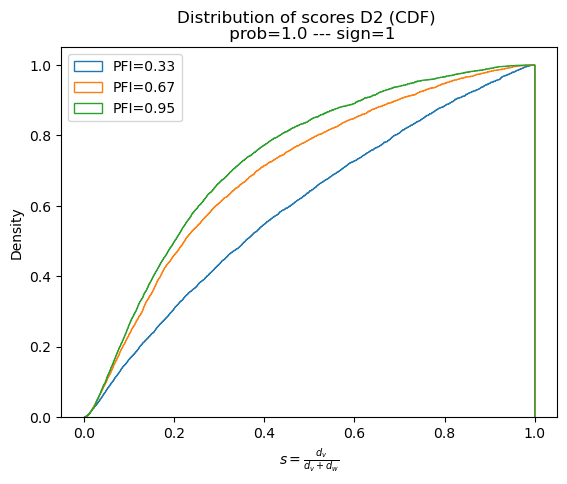

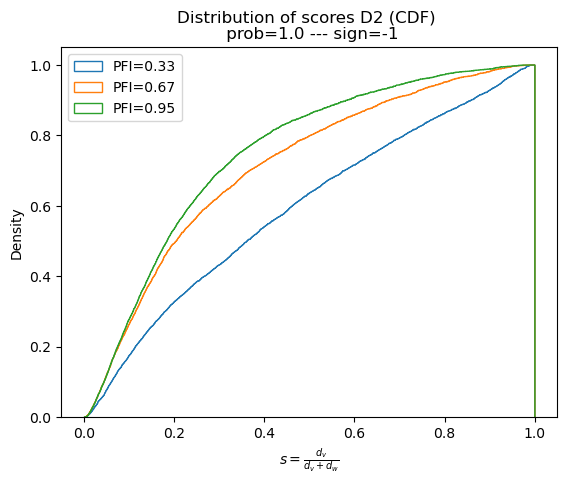

In [ ]:
N = 500
gamma = 2.0
kmin = 3
sign = 1
prob = 1.0
repetition = 1

plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n prob={prob} --- sign={sign}")

# ====================================================================
N = 500
gamma = 2.0
kmin = 3
sign = -1
prob = 1.0
repetition = 1

plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n prob={prob} --- sign={sign}")


#### "Easy cases"

Text(0.5, 1.0, 'Distribution of displacements $(d_v - d_w)$ D2 (CDF) \n pfi=0.95 --- sign=-1')

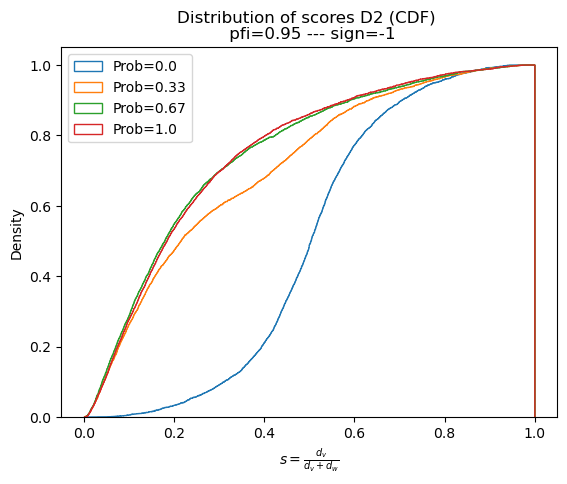

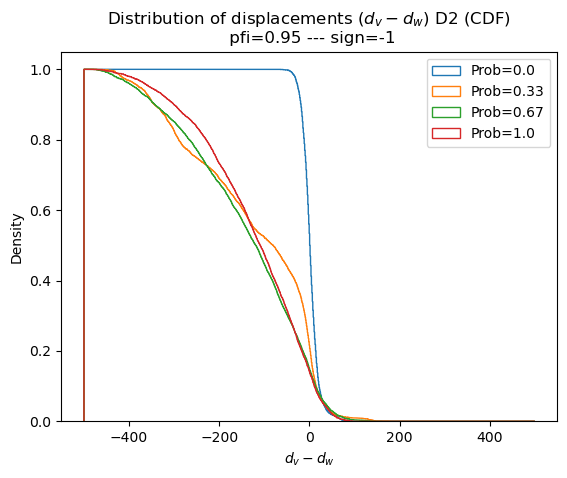

In [ ]:
N = 500
gamma = 2.0
kmin = 3
sign = -1
pfi = 0.95
repetition = 1

plt.figure()
for prob in [0.0, 0.33, 0.67, 1.0]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"Prob={prob}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n pfi={pfi} --- sign={sign}")

# ====================================================================
plt.figure()
for prob in [0.0, 0.33, 0.67, 1.0]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    deltas_higher = []
    scores_higher = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

                # R^128 distance
                v_i = original[i, :]
                v_j = original[j, :]
                w_i = shuffled[i, :]
                w_j = shuffled[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores_higher.append(d_v / (d_v + d_w))
                deltas_higher.append(abs(d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(-500, 500, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        deltas,
        histtype="step", cumulative=-1,
        bins=linbins, density=True,
        label=f"Prob={prob}",
    )


# Labels and titles
plt.legend(loc="upper right")
plt.xlabel("$d_v - d_w$")
plt.ylabel("Density")
plt.title(f"Distribution of displacements $(d_v - d_w)$ D2 (CDF) \n pfi={pfi} --- sign={sign}")

Text(0.5, 1.0, 'Distribution of displacements D2 (CDF) \n prob=0.0 --- sign=-1')

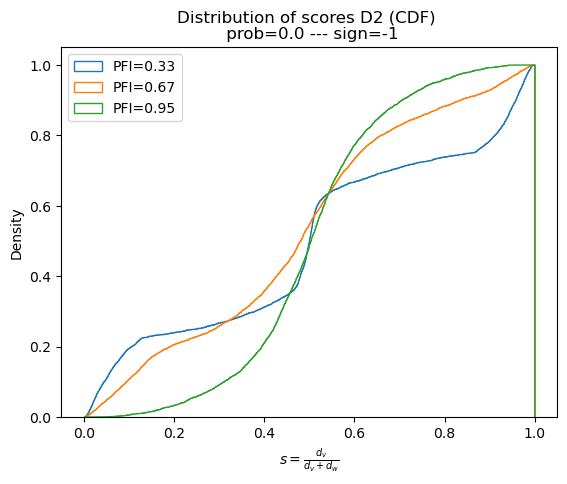

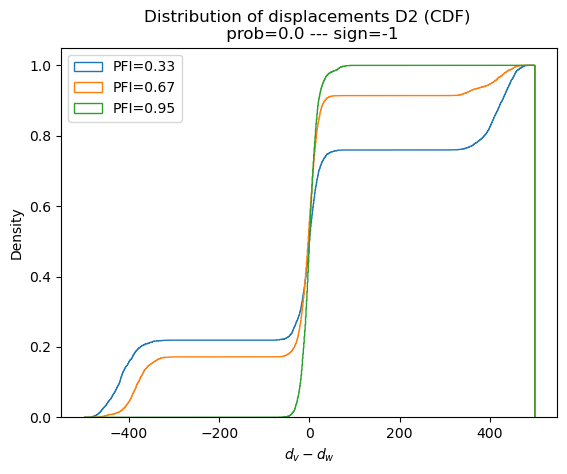

In [ ]:
N = 500
gamma = 2.0
kmin = 3
sign = -1
prob = 0.0
repetition = 1

plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n prob={prob} --- sign={sign}")

# ====================================================================
plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(-500, 500, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        deltas,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$d_v - d_w$")
plt.ylabel("Density")
plt.title(f"Distribution of displacements D2 (CDF) \n prob={prob} --- sign={sign}")

#### "Hard cases"

Text(0.5, 1.0, 'Distribution of displacements D2 (CDF) \n prob=0.0 --- sign=1')

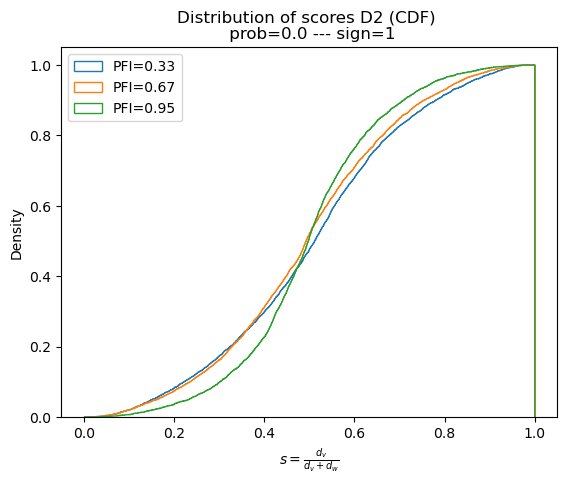

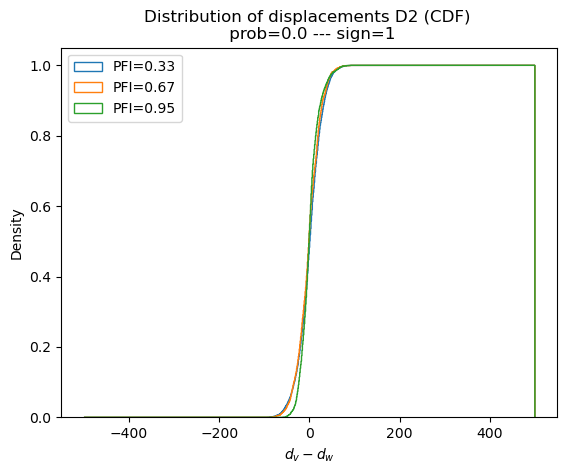

In [ ]:
N = 500
gamma = 2.0
kmin = 3
sign = 1
prob = 0.0
repetition = 1

plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n prob={prob} --- sign={sign}")

# ====================================================================
plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append((d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(-500, 500, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        deltas,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$d_v - d_w$")
plt.ylabel("Density")
plt.title(f"Distribution of displacements D2 (CDF) \n prob={prob} --- sign={sign}")

### Broader pictures

#### Displacements

In the following, larger AUC correspond to more _dissimilar_ the layer embeddings are (equivalently, the smaller the AUC, the more _similar_ the layer embeddings are)

Highly dissimilar layers are easier to classify! We want a large area!

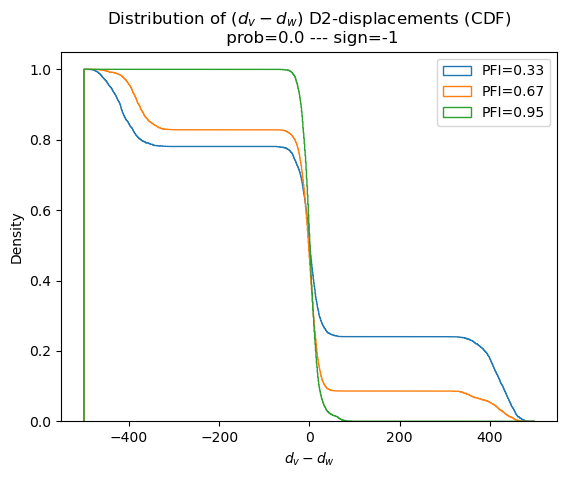

In [ ]:
N = 500
gamma = 2.0
kmin = 3
prob = 0.0
sign = -1
repetition = 1



plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append(d_v-d_w)

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(-500, 500, num=1000, endpoint=True)

    # --- (C)CDF ---
    plt.hist(
        deltas,
        histtype="step", cumulative=-1,
        bins=linbins, density=True,
        label=f"PFI={pfi}"
    )

    # Labels and titles
    plt.legend(loc="upper right")
    plt.xlabel("$d_v - d_w$")
    plt.ylabel("Density")
    plt.title(f"Distribution of $(d_v - d_w)$ D2-displacements (CDF)\n prob={prob} --- sign={sign}")

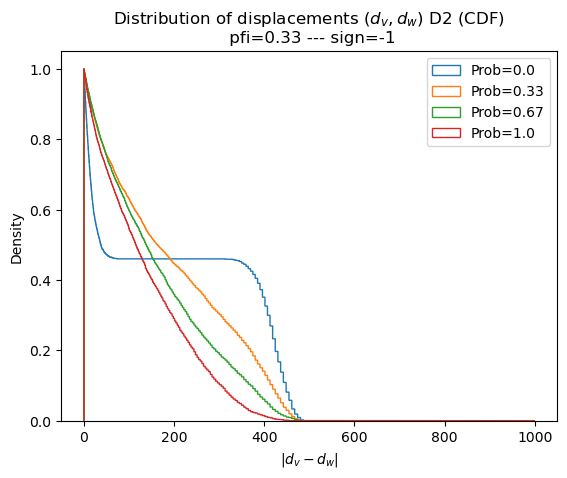

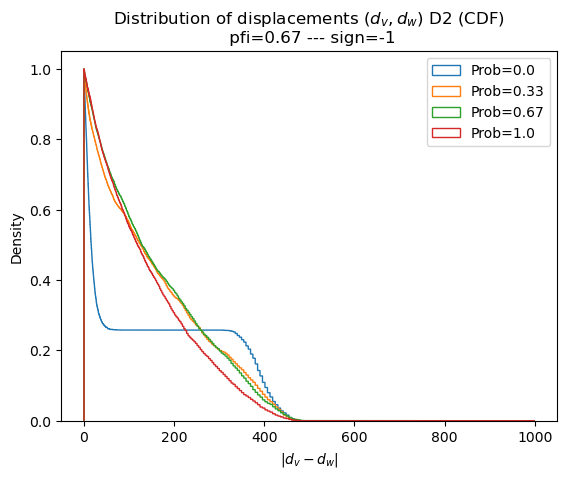

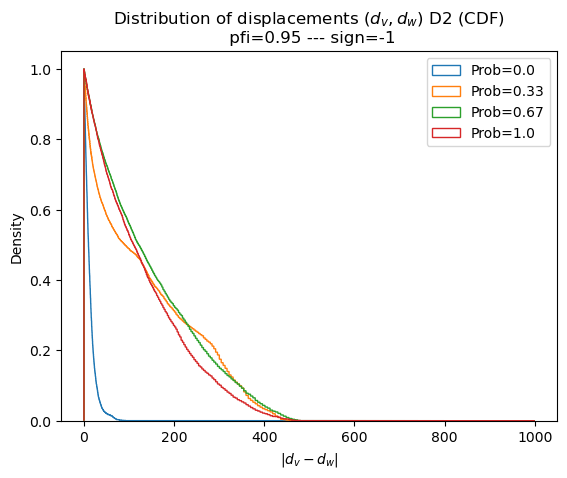

In [ ]:
N = 500
gamma = 2.0
kmin = 3
prob = 1.0
sign = -1
pfi = 0.33
repetition = 1

for pfi in [0.33, 0.67, 0.95]:
    plt.figure()
    for prob in [0.0, 0.33, 0.67, 1.0]:
        # ----- Loading some embeddings -----
        t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
        original = np.loadtxt(processed+"original"+t)
        shuffled = np.loadtxt(processed+"shuffled"+t)

        # ----- Applying PCA (-> R^2) -----
        pca = PCA(n_components=2)
        pca.fit(original)
        v = pca.transform(original)

        pca = PCA(n_components=2)
        pca.fit(shuffled)
        w = pca.transform(shuffled)


        # ----- Measuring distribution -----
        deltas = []
        scores = []
        deltas_higher = []
        scores_higher = []
        for i in range(100):
            for j in range(100):
                if i != j:
                    # R^2 distance
                    v_i = v[i, :]
                    v_j = v[j, :]
                    w_i = w[i, :]
                    w_j = w[j, :]

                    d_v = np.linalg.norm(v_i - v_j)
                    d_w = np.linalg.norm(w_i - w_j)

                    scores.append(d_v / (d_v + d_w))
                    deltas.append(abs(d_v-d_w))

                    # R^128 distance
                    v_i = original[i, :]
                    v_j = original[j, :]
                    w_i = shuffled[i, :]
                    w_j = shuffled[j, :]

                    d_v = np.linalg.norm(v_i - v_j)
                    d_w = np.linalg.norm(w_i - w_j)

                    scores_higher.append(d_v / (d_v + d_w))
                    deltas_higher.append(abs(d_v-d_w))

        # Plotting difference in distances
        # * NOTE: log-scale (C)CDFs
        logbins = np.logspace(-3, 3, num=1000, endpoint=True)
        linbins = np.linspace(0, 1, num=1000, endpoint=True)

        # --- CDF Scores ---
        plt.hist(
            deltas,
            histtype="step", cumulative=-1,
            bins=logbins, density=True,
            label=f"Prob={prob}",
        )


    # Labels and titles
    plt.legend(loc="upper right")
    plt.xlabel("$\| d_v - d_w \|$")
    plt.ylabel("Density")
    plt.title(f"Distribution of displacements $(d_v, d_w)$ D2 (CDF) \n pfi={pfi} --- sign={sign}")

#### Scores

Text(0.5, 1.0, 'Distribution of scores D2 (CDF) \n prob=0.0 --- sign=-1')

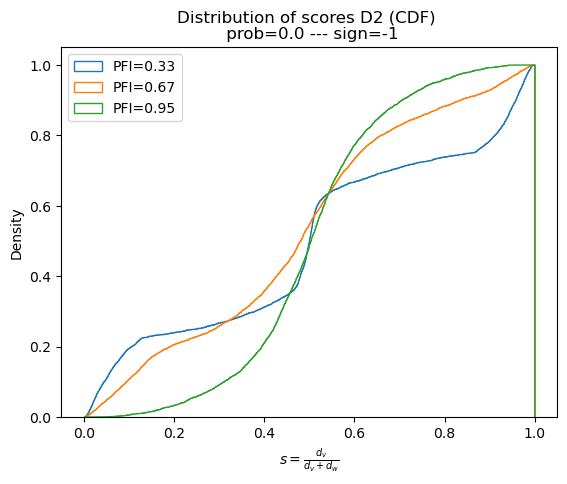

In [ ]:
N = 500
gamma = 2.0
kmin = 3
prob = 0.0
sign = -1
pfi = 0.33
repetition = 1



plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append(abs(d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )

# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n prob={prob} --- sign={sign}")

Text(0.5, 1.0, 'Distribution of scores D2 (CDF) \n prob=1.0 --- sign=-1')

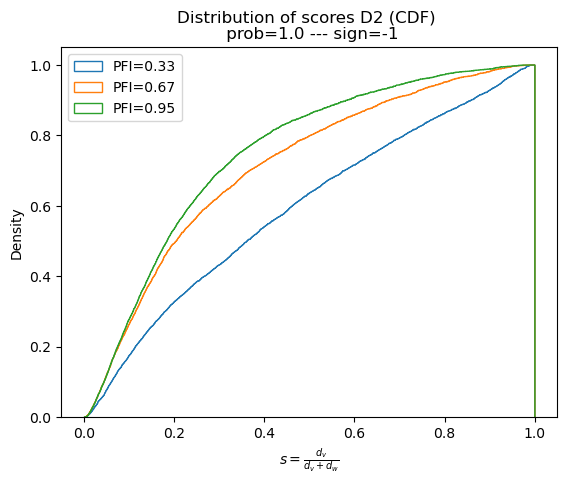

In [ ]:
N = 500
gamma = 2.0
kmin = 3
prob = 1.0
sign = -1
pfi = 0.33
repetition = 1



plt.figure()
for pfi in [0.33, 0.67, 0.95]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append(abs(d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"PFI={pfi}",
    )

# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n prob={prob} --- sign={sign}")

Text(0.5, 1.0, 'Distribution of scores D2 (CDF) \n pfi=0.95 --- sign=-1')

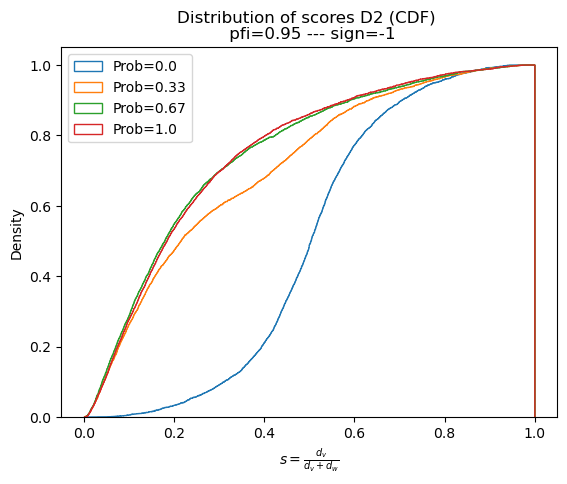

In [ ]:
N = 500
gamma = 2.0
kmin = 3
sign = -1
pfi = 0.95
repetition = 1

plt.figure()
for prob in [0.0, 0.33, 0.67, 1.0]:
    # ----- Loading some embeddings -----
    t = f"-vectors_N={N}_gamma={gamma}_kmin={kmin}_prob={prob}_sign={sign}_pfi={pfi}_repetition={repetition}.mat"
    original = np.loadtxt(processed+"original"+t)
    shuffled = np.loadtxt(processed+"shuffled"+t)

    # ----- Applying PCA (-> R^2) -----
    pca = PCA(n_components=2)
    pca.fit(original)
    v = pca.transform(original)

    pca = PCA(n_components=2)
    pca.fit(shuffled)
    w = pca.transform(shuffled)


    # ----- Measuring distribution -----
    deltas = []
    scores = []
    for i in range(100):
        for j in range(100):
            if i != j:
                # R^2 distance
                v_i = v[i, :]
                v_j = v[j, :]
                w_i = w[i, :]
                w_j = w[j, :]

                d_v = np.linalg.norm(v_i - v_j)
                d_w = np.linalg.norm(w_i - w_j)

                scores.append(d_v / (d_v + d_w))
                deltas.append(abs(d_v-d_w))

    # Plotting difference in distances
    # * NOTE: log-scale (C)CDFs
    logbins = np.logspace(-3, 3, num=1000, endpoint=True)
    linbins = np.linspace(0, 1, num=1000, endpoint=True)

    # --- CDF Scores ---
    plt.hist(
        scores,
        histtype="step", cumulative=1,
        bins=linbins, density=True,
        label=f"Prob={prob}",
    )


# Labels and titles
plt.legend(loc="upper left")
plt.xlabel("$ s = \\frac{d_v}{d_v + d_w} $")
plt.ylabel("Density")
plt.title(f"Distribution of scores D2 (CDF) \n pfi={pfi} --- sign={sign}")

# Analysis
---

## Post-processing data

## Visualization

### Initial exploration

<Figure size 640x480 with 0 Axes>

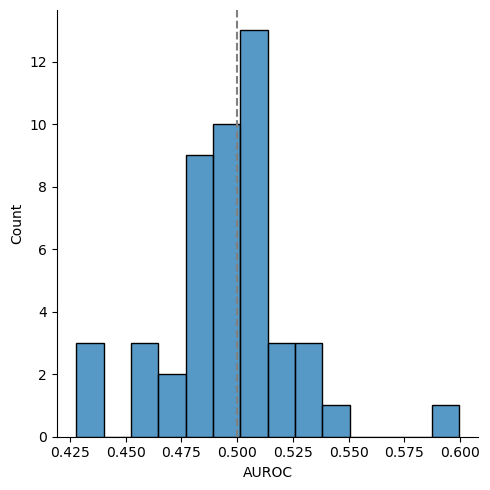

In [177]:
# Declare figure
plt.figure()
figure_ = sns.displot(
    data=df, kind="hist",
    x="AUROC"
)

# Format figure
figure_ = (
    figure_
    .refline(x=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/hist_auroc_{template_}.png")
figure_

<Figure size 640x480 with 0 Axes>

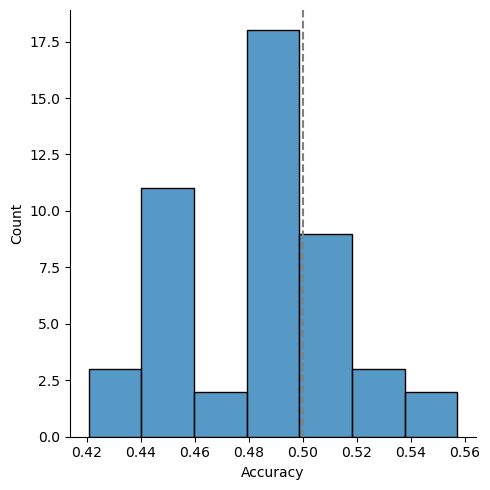

In [205]:
# Declare figure
plt.figure()
figure_ = sns.displot(
    data=df, kind="hist",
    x="Accuracy"
)

# Format figure
figure_ = (
    figure_
    .refline(x=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/hist_accuracy_{template_}.png")
figure_

<Figure size 640x480 with 0 Axes>

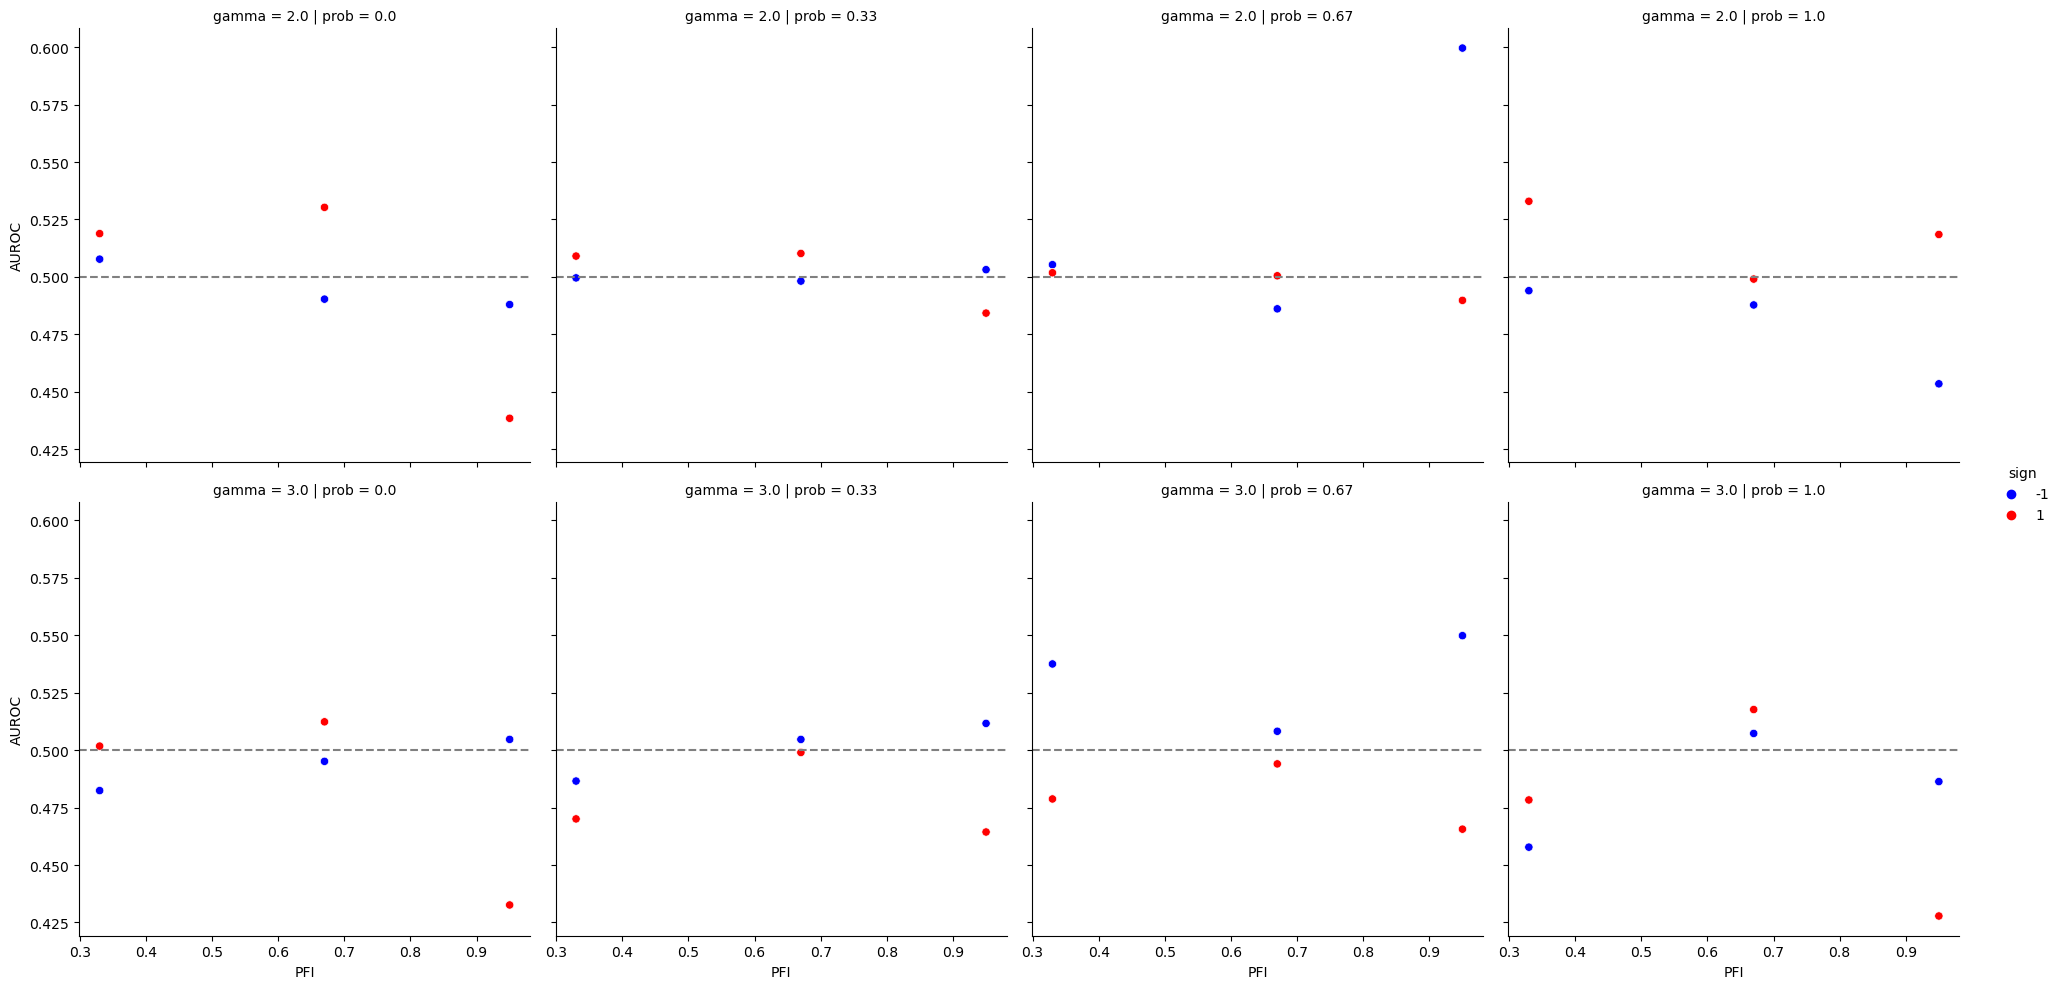

In [178]:
# Declare figure
plt.figure()
figure_ = sns.relplot(
    data=df, kind="scatter",
    x="pfi", y="AUROC",
    row="gamma",
    col="prob",
    hue="sign", palette=["blue", "red"]
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("PFI", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/faceted-scatter_auroc-pfi-gamma-prob-sign_{template_}.png")
figure_

### Effect of PFI

<Figure size 640x480 with 0 Axes>

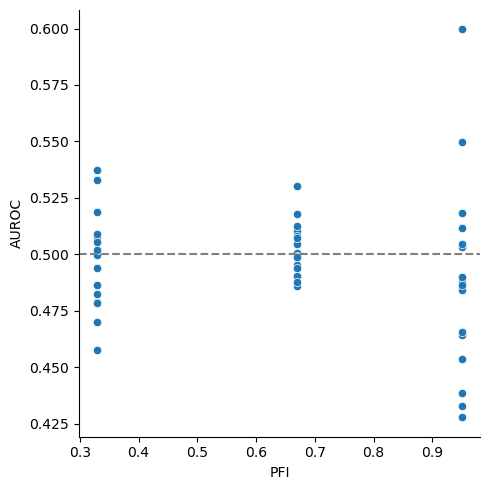

In [101]:
# Declare figure
plt.figure()
figure_ = sns.relplot(
    data=df, kind="scatter",
    x="pfi", y="AUROC",
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("PFI", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/scatter_auroc-pfi_{template_}.png")
figure_

### Effect of degree heterogeneity ($\gamma$)

<Figure size 640x480 with 0 Axes>

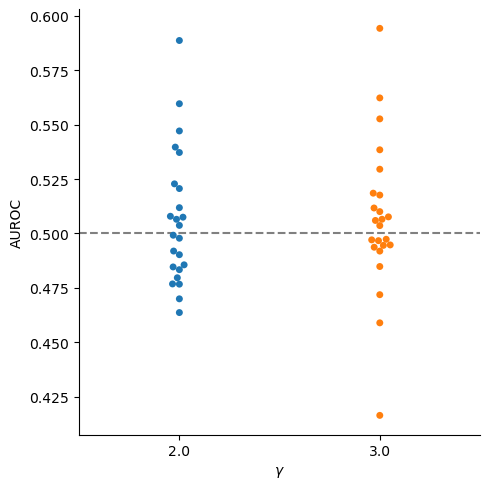

In [13]:
# Declare figure
plt.figure()
figure_ = sns.catplot(
    data=df, kind="swarm",
    x="gamma", y="AUROC",
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("$\gamma$", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/swarm_auroc-gamma_{template_}.png")
figure_

<Figure size 640x480 with 0 Axes>

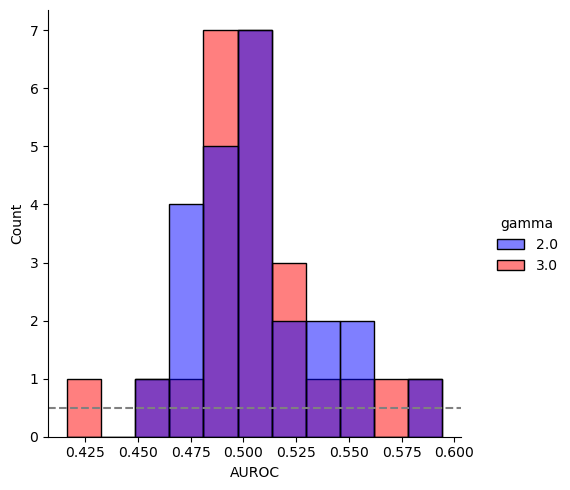

In [14]:
# Declare figure
plt.figure()
figure_ = sns.displot(
    data=df, kind="hist",
    x="AUROC",
    hue="gamma", palette=["blue", "red"]
)

# Format figure
figure_ = (
    figure_
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/hist_auroc-gamma_{template_}.png")
figure_

### Effect of correlation prob

<Figure size 640x480 with 0 Axes>

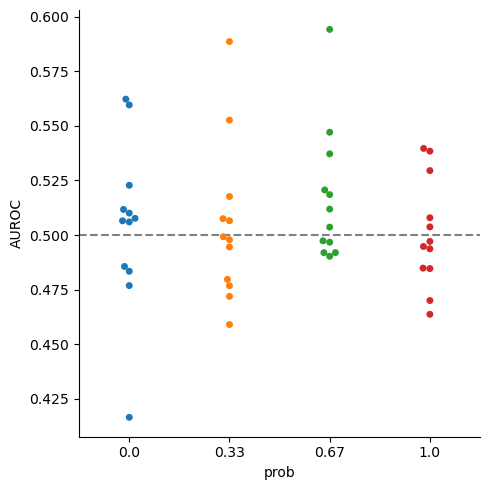

In [15]:
# Declare figure
plt.figure()
figure_ = sns.catplot(
    data=df, kind="swarm",
    x="prob", y="AUROC",
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("prob", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/swarm_auroc-prob_{template_}.png")
figure_

### Effect of sorting (sign)

<Figure size 640x480 with 0 Axes>

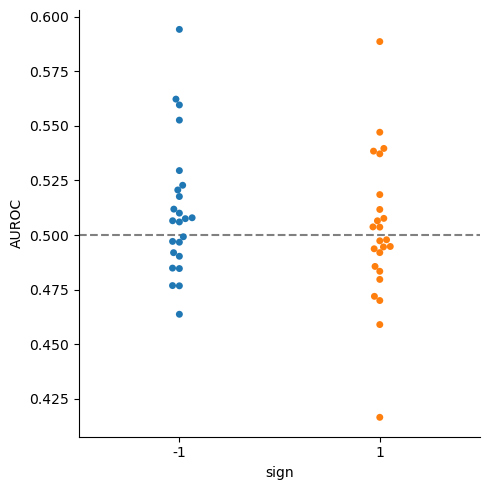

In [16]:
# Declare figure
plt.figure()
figure_ = sns.catplot(
    data=df, kind="swarm",
    x="sign", y="AUROC",
)

# Format figure
figure_ = (
    figure_
    .set_axis_labels("sign", "AUROC")
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/swarm_auroc-sign_{template_}.png")
figure_

<Figure size 640x480 with 0 Axes>

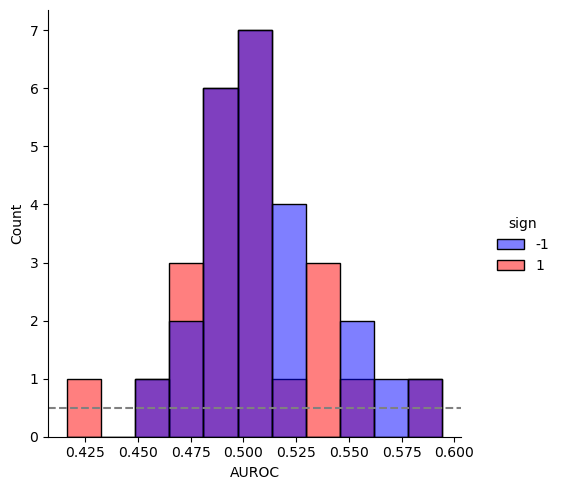

In [17]:
# Declare figure
plt.figure()
figure_ = sns.displot(
    data=df, kind="hist",
    x="AUROC",
    hue="sign", palette=["blue", "red"]
)

# Format figure
figure_ = (
    figure_
    .refline(y=0.5)
)

# Save and display figure
plt.savefig(f"{figures}/hist_auroc-sign_{template_}.png")
figure_

# Discussion
---

## Observations

Currently, the AUROC seems to be centered about 0.5 regardless of parameters.

## Interpretations

The clear centering of $AUROC \approx 0.5$ suggests that there is no noticeable effect from the parameters of the duplex. This certainly seems nonsensical, suggesting some bug.

I have implemented PCA reduction here, however, and found there is still little difference in reconstruction performance. While I have a handful of things I can rule out (will add later), I am currently unsure what _is_ the problem, if any - perhaps this just sucks as a method for multiplex reconstruction?

Note that I have also restricted to just the largest component of each remnant so the node2vec random walks wouldn't have to worry about isolated nodes.

## Follow-up

For further investigations with node2vec, I am uncertain where to begin. I will leave this here and get Filippo's feedback. In the meantime, I will move to EMB_ex03 and explore Mercator, a hyperbolic embedding.